In [184]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle

## Обработка данных

Считаем датасет и выведем основные статистики 

In [185]:
data = pd.read_csv('data/df_hw.csv', index_col=0)

In [186]:
data['day'].unique()

array([ 8,  5, 15,  1,  7,  9,  2, 11,  4, 16, 13,  0, 14,  3, 18, 12,  6,
       10, 19, 17], dtype=int64)

In [187]:
data.head()

,user_id,metric,day
4768,4768,5210.050500,8
1928,1928,1617.534800,8
2995,2995,6742.954000,5
15885,5885,8998.112105,15
6121,6121,2281.206200,1


In [188]:
data.describe()

,user_id,metric,day
count,20000.000000,20000.000000,20000.000000
mean,4999.500000,5608.495781,9.500000
std,2886.823503,2694.961977,5.766425
min,0.000000,1000.208700,0.000000
25%,2499.750000,3529.527850,4.750000
50%,4999.500000,5325.799848,9.500000
75%,7499.250000,7531.320458,14.250000
max,9999.000000,15645.966244,19.000000


Разобьем данные на 2 группы (первые десять дней, вторые десять дней)

In [189]:
data_aa_1 = data[data['day'] <= 9]

In [190]:
data_aa_2 = data[data['day'] > 9]

Посмотрим на распределение данных

(array([426., 490., 531., 556., 533., 579., 562., 595., 617., 624., 644.,
        662., 634., 628., 361., 212., 179., 139., 112., 102., 114.,  82.,
         78.,  78.,  65.,  67.,  67.,  59.,  70.,  40.,  47.,  47.]),
 array([1000.2087    , 1281.05661563, 1561.90453125, 1842.75244688,
        2123.6003625 , 2404.44827813, 2685.29619375, 2966.14410938,
        3246.992025  , 3527.83994063, 3808.68785625, 4089.53577188,
        4370.3836875 , 4651.23160313, 4932.07951875, 5212.92743438,
        5493.77535   , 5774.62326563, 6055.47118125, 6336.31909688,
        6617.1670125 , 6898.01492813, 7178.86284375, 7459.71075938,
        7740.558675  , 8021.40659063, 8302.25450625, 8583.10242188,
        8863.9503375 , 9144.79825312, 9425.64616875, 9706.49408438,
        9987.342     ]),
 <BarContainer object of 32 artists>)

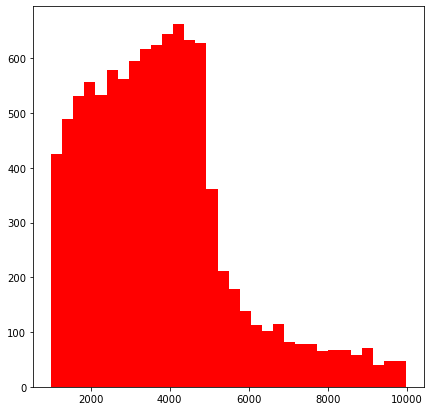

In [191]:
plt.figure(figsize=(7,7))
plt.hist(data_aa_1['metric'], bins = 32, color='red',  linewidth=2)

(array([  1.,  22.,  24.,  60., 131., 220., 403., 537., 644., 725., 798.,
        873., 850., 917., 784., 681., 527., 417., 305., 251., 165., 118.,
        113., 109.,  82.,  86.,  66.,  46.,  23.,  14.,   3.,   5.]),
 array([ 1812.18974488,  2244.49526049,  2676.8007761 ,  3109.10629171,
         3541.41180732,  3973.71732293,  4406.02283854,  4838.32835415,
         5270.63386976,  5702.93938537,  6135.24490098,  6567.55041659,
         6999.8559322 ,  7432.16144781,  7864.46696343,  8296.77247904,
         8729.07799465,  9161.38351026,  9593.68902587, 10025.99454148,
        10458.30005709, 10890.6055727 , 11322.91108831, 11755.21660392,
        12187.52211953, 12619.82763514, 13052.13315075, 13484.43866636,
        13916.74418197, 14349.04969759, 14781.3552132 , 15213.66072881,
        15645.96624442]),
 <BarContainer object of 32 artists>)

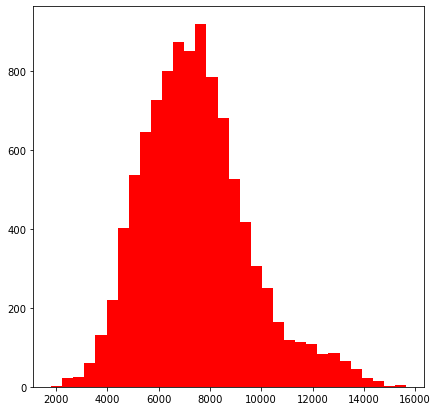

In [192]:
plt.figure(figsize=(7,7))
plt.hist(data_aa_2['metric'], bins = 32, color='red',  linewidth=2)

## A/A и A/B Тест

Добавим эффект в 2% за максимально возможное число дней и подберем такую подвыборку, что получим мощность более 80%

In [193]:
def generate_group_aa_ab(data_1, data_2, eff_size):
    group_len = int(len(data_1) / 2)
    group_A_aa_df = data_1.sample(n = group_len)
    group_A_aa = group_A_aa_df['metric']
    group_A_aa_ind = group_A_aa_df['user_id'].values
    group_B_aa = data_1[~data_1['user_id'].isin(group_A_aa_ind)]['metric']
    group_A_ab = data_2[data_2['user_id'].isin(group_A_aa_ind)]['metric']
    group_B_ab = data_2[~data_2['user_id'].isin(group_A_aa_ind)]['metric'] * (1. + eff_size)
    return group_A_aa, group_B_aa, group_A_ab, group_B_ab

In [194]:
p_values_aa = []
p_values_ab = []
iters = 10000
alpha = 0.05
eff_size = 0.02
for _ in range(iters):
    group_A_aa, group_B_aa, group_A_ab, group_B_ab = generate_group_aa_ab(data_aa_1, data_aa_2, eff_size)
    #A/A
    p = scipy.stats.ttest_ind(group_A_aa, group_B_aa, equal_var=False).pvalue
    p_values_aa.append(p)
    #A/B
    p = scipy.stats.ttest_ind(group_A_ab, group_B_ab, equal_var=False).pvalue
    p_values_ab.append(p)
p_values_aa = np.array(p_values_aa)
p_values_ab = np.array(p_values_ab)
print(f"A/A: {p_values_aa[p_values_aa < alpha].shape[0] / p_values_aa.shape[0]}")
print(f"A/B: {p_values_ab[p_values_ab < alpha].shape[0] / p_values_ab.shape[0]}")

A/A: 0.0515
A/B: 0.9397


Отсюда убеждаемся, что мы можем зафиксировать эффект в 2% с вероятностью 80% для максимально возможного числа дней.

(array([ 981., 1015.,  986., 1006., 1010.,  975.,  989., 1011., 1046.,
         981.]),
 array([1.90349021e-05, 1.00012118e-01, 2.00005201e-01, 2.99998285e-01,
        3.99991368e-01, 4.99984451e-01, 5.99977534e-01, 6.99970617e-01,
        7.99963701e-01, 8.99956784e-01, 9.99949867e-01]),
 <BarContainer object of 10 artists>)

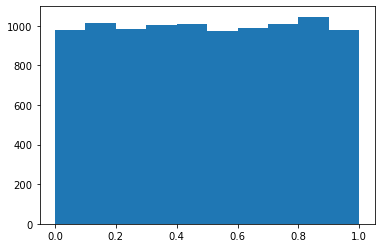

In [195]:
plt.hist(p_values_aa)

(array([9.611e+03, 2.090e+02, 8.400e+01, 3.400e+01, 2.800e+01, 1.200e+01,
        8.000e+00, 5.000e+00, 6.000e+00, 3.000e+00]),
 array([6.67298053e-15, 8.60398903e-02, 1.72079781e-01, 2.58119671e-01,
        3.44159561e-01, 4.30199451e-01, 5.16239342e-01, 6.02279232e-01,
        6.88319122e-01, 7.74359013e-01, 8.60398903e-01]),
 <BarContainer object of 10 artists>)

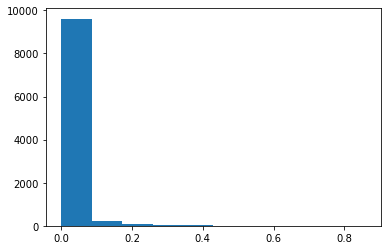

In [196]:
plt.hist(p_values_ab)

Далее найдем минимальное количество дней, при котором вылавливается эффект в 2% с вероятностью 80%

In [197]:
def criteria(group_A, group_B, criteria_value='ttest_ind'):
    if criteria_value == 'mannwhitneyu':
        return scipy.stats.mannwhitneyu(group_A, group_B, alternative='two-sided').pvalue
    else:
        return scipy.stats.ttest_ind(group_A, group_B, equal_var=False).pvalue
        

Функция power_by_n_days возвращает power(мощность) и массив p_value для эксперимента длительностью в n_days дней для групп размером group_size из выборки df, с количеством итераций iters, с эффектом eff_size, с уровнем значимости alpha, c критерием criteria_value

In [201]:
def generate_group_aa_ab_2(data_1, data_2, eff_size):
    group_len = int(len(data_1) / 2)
    group_A_aa_df = data_1.sample(n = group_len)
    group_A_aa = group_A_aa_df['metric']
    group_A_aa_ind = group_A_aa_df['user_id'].values
    group_B_aa = data_1[~data_1['user_id'].isin(group_A_aa_ind)]['metric'] * (1. + eff_size)
    group_A_ab = data_2[data_2['user_id'].isin(group_A_aa_ind)]['metric']
    group_B_ab = data_2[~data_2['user_id'].isin(group_A_aa_ind)]['metric']
    return group_A_aa, group_B_aa, group_A_ab, group_B_ab

In [205]:
def power_by_n_days(df, df_2, n_days, eff_size=0.02, iters=10000, alpha=0.05, group_size = None, criteria_value='ttest_ind'):
    max_days = int(max(df['day'].unique())) + 1
    data_start = int(min(df['day'].unique()))
    data_end = data_start + n_days - 1
    days_iters = max_days - data_start - n_days + 1
    p_values_aa = []
    p_values_ab = []
    power_aa = []
    power_ab = []
    for i in range(days_iters):
        data_current = df[((df['day'] >= (data_start + i)) & (df['day'] <= (data_end + i)))]
        if((group_size is None) or (group_size > len(data_current))):
            group_size = len(data_current)
        p_values_current_aa = []
        p_values_current_ab = []
        for _ in range(iters):
            group_A_ab, group_B_ab, group_A_aa, group_B_aa = generate_group_aa_ab_2(data_current, df_2, eff_size)
            # A/A
            p_aa = criteria(group_A_aa, group_B_aa, criteria_value)
            p_values_current_aa.append(p_aa)
            # A/B
            p_ab = criteria(group_A_ab, group_B_ab, criteria_value)
            p_values_current_ab.append(p_ab)
        p_values_current_aa = np.array(p_values_current_aa)
        p_values_current_ab = np.array(p_values_current_ab)
        p_values_aa.append(p_values_current_aa)
        p_values_ab.append(p_values_current_ab)
        power_aa.append(p_values_current_aa[p_values_current_aa < alpha].shape[0] / p_values_current_aa.shape[0])
        power_ab.append(p_values_current_ab[p_values_current_ab < alpha].shape[0] / p_values_current_ab.shape[0])
    return p_values_aa, power_aa, p_values_ab, power_ab

Мы запустили функцию для количества дней от 3 до 20 (ресурсоемко). Ниже приведен фрагмент кода для быстрого поиска минимального количества дней.

Найдем нужное количество дней. Для этого найдем минимальное количество дней, для которого все мощности больше 0.8:

In [206]:
min_n_days = 1
for j in range(1, 10):
    p_values_results_current_aa, power_results_current_aa, p_values_results_current_ab, power_results_current_ab = power_by_n_days(data_aa_2, data_aa_1, j)
    power_results_current_aa = np.array(power_results_current_aa)
    power_results_current_ab = np.array(power_results_current_ab)
    print(power_results_current_aa, power_results_current_ab)
    # Проверим, что нет ни одного промежутока,который бы не удовлетворял условию того, что мощность менее 80%
    if ((len(power_results_current_ab[power_results_current_ab < 0.8]) == 0) and (len(power_results_current_aa[power_results_current_aa >= 0.8]) == 0)):
        min_n_days = j
        break
print(f"Минимальное количество дней: {min_n_days}")

[0.1237 0.0089 0.0069 0.0598 0.0956 0.0066 0.0424 0.0084 0.0175 0.0101] [0.2076 0.2001 0.1952 0.1912 0.192  0.2036 0.1975 0.1982 0.2306 0.1974]
[0.0695 0.0083 0.0447 0.2185 0.0496 0.028  0.0139 0.0099 0.0185] [0.3562 0.3487 0.3405 0.3272 0.3337 0.3573 0.3494 0.3757 0.3719]
[0.042  0.0334 0.1658 0.1383 0.0133 0.0164 0.0311 0.0111] [0.4879 0.4757 0.4735 0.4743 0.4747 0.488  0.5243 0.5091]
[0.0134 0.1279 0.1335 0.0554 0.0228 0.0299 0.0329] [0.5974 0.5933 0.583  0.5919 0.6005 0.6261 0.6207]
[0.0373 0.1126 0.0617 0.0752 0.0148 0.0401] [0.6925 0.6906 0.6872 0.6936 0.7094 0.7052]
[0.0341 0.0595 0.0782 0.05   0.0192] [0.7726 0.7628 0.7674 0.7797 0.7791]
[0.027  0.0799 0.0609 0.0465] [0.8274 0.8305 0.8385 0.8359]
Минимальное количество дней: 7


## Возможные улучшения для детектирования эффекта в 2% для 3-ех дней

Мощность критерия зависит от следующих факторов:
1. размер выборки;
2. размер отклонения от нулевой гипотезы;
3. чувствительность статистики критерия;
4. тип альтернативы.

Для увеличения мощности необходимо увеличить размер выборки (текущей не хватает). При уменьшении размера выборки мощность уменьшается для эффекта в 2%.

Пункты 2-4 по факту зависят от выбранного критерия

Проверим детектируется ли эффект в 2% для критерия Стьюдента и Манна-Уитни в течении 3-ех дней

In [ ]:
p_values_3_aa, power_3_aa, p_values_3_ab, power_3_ab  = power_by_n_days(data_aa_2, data_aa_1, 3)
power_3_aa = np.array(power_3_aa)
power_3_ab = np.array(power_3_ab)

In [ ]:
# Проверим есть ли хотя бы один промежуток,который удовлетворяет условию того, что мощность менее 80%
if(len(power_3_ab[power_3_ab < 0.8]) != 0):
    print("Есть промежуток, мощность которого менее 80% => при таких условиях не можем задетекить эффект в 2%")

Для критерия Стьюдента (как видим из данных выше) 3-ех дней не хватает для детектирования 2% эффекта (возможно, необходимо просмотреть другие, более мощные критерии)

In [ ]:
p_values_3_aa, power_3_aa, p_values_3_ab, power_3_ab = power_by_n_days(data_aa_2, data_aa_1, 3, criteria_value='mannwhitneyu')
power_3_aa = np.array(power_3_aa)
power_3_ab = np.array(power_3_ab)

In [ ]:
# Проверим есть ли хотя бы один промежуток,который удовлетворяет условию того, что мощность менее 80%
if(len(power_3_ab[power_3_ab < 0.8]) != 0):
    print("Есть промежуток, мощность которого менее 80% => при таких условиях не можем задетекить эффект в 2%")

Для критерия Манна-Уитни (как видим из данных выше) 3-ех дней не хватает для детектирования 2% эффекта (возможно, необходимо просмотреть другие, более мощные критерии)